# Capstone Project

## A report on Road traffic accidents in Leeds

### Introduction

In this report i'll be looking at information on accidents across Leeds. 

It is important to prevent avoidable car accidents by employing methods that alert drivers and remind them to be more careful in critical situations.

In most cases, not paying enough attention during driving, abusing drugs and alcohol or driving at very high speed are the main causes of occurring accidents that can be prevented by enacting harsher regulations.

Besides the aforementioned reasons, weather, visibility, or road conditions are the major uncontrollable factors that can be prevented by revealing hidden patterns in the data and announcing warning to the local government, police and drivers on the targeted roads. The model and its results are going to provide some advice for the target audience to make insightful decisions for reducing the number of accidents and injuries for the city.

The data includes location, number of people and vehicles involved, road surface, weather conditions and severity of any casualties. I want to see if there is a correlation between the severity of the accident with possible determinants including weather conditions.

### Data

The dataset that i'll be using can be found <a href="https://data.gov.uk/dataset/6efe5505-941f-45bf-b576-4c1e09b579a1/road-traffic-accidents">here</a>

The __Traffic accidents_2019_Leeds.csv__ data set includes details of 1907 accidents that were logged when the incident occured. It includes following fields:

| Field          | Description                                                                           |
|---------------- |---------------------------------------------------------------------------------------|
| Reference Number    | Alphanumeric to identify the accident                                           |
| Number of Vehicles      | The number of vehicles involved                                                    |
| Accident Date          | Date of accident |
| Time (24hr) | Time of accident                                         |
| Road Surface       | Type of road surface                |
| Lighting Conditions            | E.g day, night                                                                      |
| Weather Conditions      | E.g wet, dry                                                                |
| Casualty Severity         | numeric from 1-3 where 1 is most severe and 3 is least severe                                                               
|Age of Casualty|  age |
|Sex of casualty | numeric where 1=male, 2=female  |

There are other fields however i'll drop them from my dataframe.

In [355]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
mpl.style.use('ggplot')
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import datetime

In [356]:
#for later use
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [357]:
df = pd.read_csv('Traffic accidents_2019_Leeds.csv')

### Methodology

#### Explore dataset and exploratory analysis

In [358]:
df.shape

(1907, 18)

In [359]:
#scan for incomplete data
df.isna().sum()

Reference Number       0
Grid Ref: Easting      0
Grid Ref: Northing     0
Number of Vehicles     0
Accident Date          0
Time (24hr)            0
1st Road Class         0
1st Road Class & No    0
Road Surface           0
Lighting Conditions    0
Weather Conditions     0
Local Authority        0
Vehicle Number         0
Type of Vehicle        0
Casualty Class         0
Casualty Severity      0
Sex of Casualty        0
Age of Casualty        0
dtype: int64

In [360]:
df.dtypes

Reference Number       object
Grid Ref: Easting       int64
Grid Ref: Northing      int64
Number of Vehicles      int64
Accident Date          object
Time (24hr)             int64
1st Road Class          int64
1st Road Class & No    object
Road Surface            int64
Lighting Conditions     int64
Weather Conditions      int64
Local Authority        object
Vehicle Number          int64
Type of Vehicle         int64
Casualty Class          int64
Casualty Severity       int64
Sex of Casualty         int64
Age of Casualty         int64
dtype: object

In [361]:
df.columns

Index(['Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing',
       'Number of Vehicles', 'Accident Date', 'Time (24hr)', '1st Road Class',
       '1st Road Class & No', 'Road Surface', 'Lighting Conditions',
       'Weather Conditions', 'Local Authority', 'Vehicle Number',
       'Type of Vehicle', 'Casualty Class', 'Casualty Severity',
       'Sex of Casualty', 'Age of Casualty'],
      dtype='object')

In [362]:
#drop unneccessary columns
df.drop(columns=['Grid Ref: Easting', 'Grid Ref: Northing','1st Road Class','1st Road Class & No','Local Authority', 'Vehicle Number','Type of Vehicle', 'Casualty Class'], inplace=True)

#rename columns to make them easier to work with
df.rename(columns={'Reference Number':'id', 'Accident Date':'date','Time (24hr)':'time', 'Lighting Conditions':'lighting', 'Weather Conditions':'weather', 'Casualty Severity':'severity', 'Sex of Casualty':'gender', 'Age of Casualty':'age'}, inplace=True)

#instead of having gender = 1,2 i'd like to replace it with 0,1 for familiarity
df.gender.replace(to_replace=[1,2], value=[0,1],inplace=True)

#change accident date from object to datetime
df['date'] = pd.to_datetime(df['date'])

#change time from int to str to make it easier to work with
df.time = df.time.astype(str)


In [363]:
df.head(12)

,id,Number of Vehicles,date,time,Road Surface,lighting,weather,severity,gender,age
0,58F1730,2,2019-08-15,1812,1,1,1,3,1,6
1,58F1730,2,2019-08-15,1812,1,1,1,3,0,9
2,58F1730,2,2019-08-15,1812,1,1,1,3,1,39
3,58F1730,2,2019-08-15,1812,1,1,1,3,0,5
4,58F1730,2,2019-08-15,1812,1,1,1,3,1,8
5,58F1730,2,2019-08-15,1812,1,1,1,3,1,48
6,58F1730,2,2019-08-15,1812,1,1,1,3,1,57
7,6111190,2,2019-01-01,1007,1,1,1,3,0,54
8,6111674,1,2019-01-01,1505,1,1,1,3,1,3
9,6111836,2,2019-01-01,1640,1,4,1,2,0,45


In [364]:
# We cannot work with that time format so I will change it to a time format that we can work with
L= []
for t in df.time:
    if len(t)==4:  
        x = t[:2]+":"+ t[2:]
    elif len(t)==3:
        x = "0"+t[:1]+":"+t[1:]
    elif len(t)==2:
        x = "00:"+t[:]
    else:
        x = "00:0"+t[:]
    L.append(x)
    
df['time'] = L

df.time = pd.to_datetime(df.time, format='%H:%M')
df.time = df.time - datetime.datetime.strptime('00:00', '%H:%M')

In [409]:
#I'd like to see at what time of day accidents are most likely to occur.
#To do this, i'll create a new time_df with the time column as the index
time_df = df.set_index('time')

#i'll then drop the unecessary columns from the time_df
time_df.drop(columns=['Number of Vehicles','date','Road Surface','lighting','weather','severity','gender','age'],inplace=True)

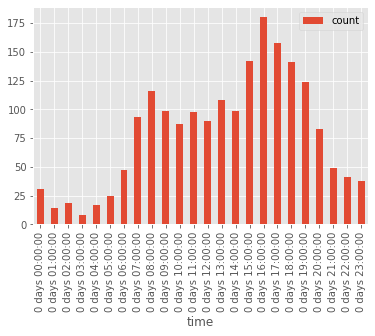

In [451]:
#I can use the groupby function to count the frequency of incidents by hour
ax = time_df.groupby(pd.Grouper(freq='60Min', label='right')).count()
ax.plot(kind='bar')
L = plt.legend()
L.get_texts()[0].set_text('count')

My initial thought was that there would be more accidents late at night/early morning due to lack of visibility/people driving intoxicated. However, I can now intuitively see that most accidents occur during peak times (between 3-6pm)

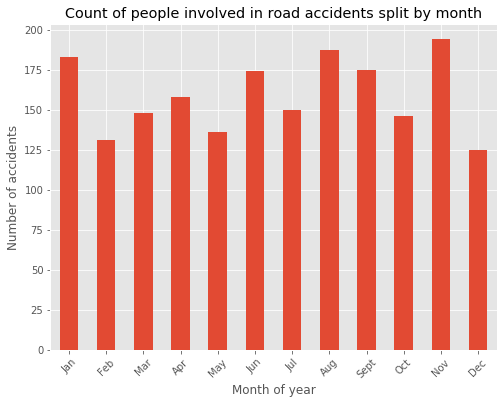

In [336]:
#I'd now like to see what month of the year have the most incidents
out = pd.cut(df.date, bins=12, include_lowest=False)
ax= out.value_counts(sort=False).plot.bar(figsize=(8,6))
names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.xlabel("Month of year")
plt.ylabel("Number of accidents")
plt.title("Count of people involved in road accidents split by month")
ax.set_xticklabels(names, rotation=45)
plt.show()

As we can see, November seems to be when most accidents occur, closely followed by August and January. I don't think there's much intuition that can help provide insights into why that is. I can see that December has the lowest incidents, this may be because of people taking time off for christmas and new year which means overall less commuting.

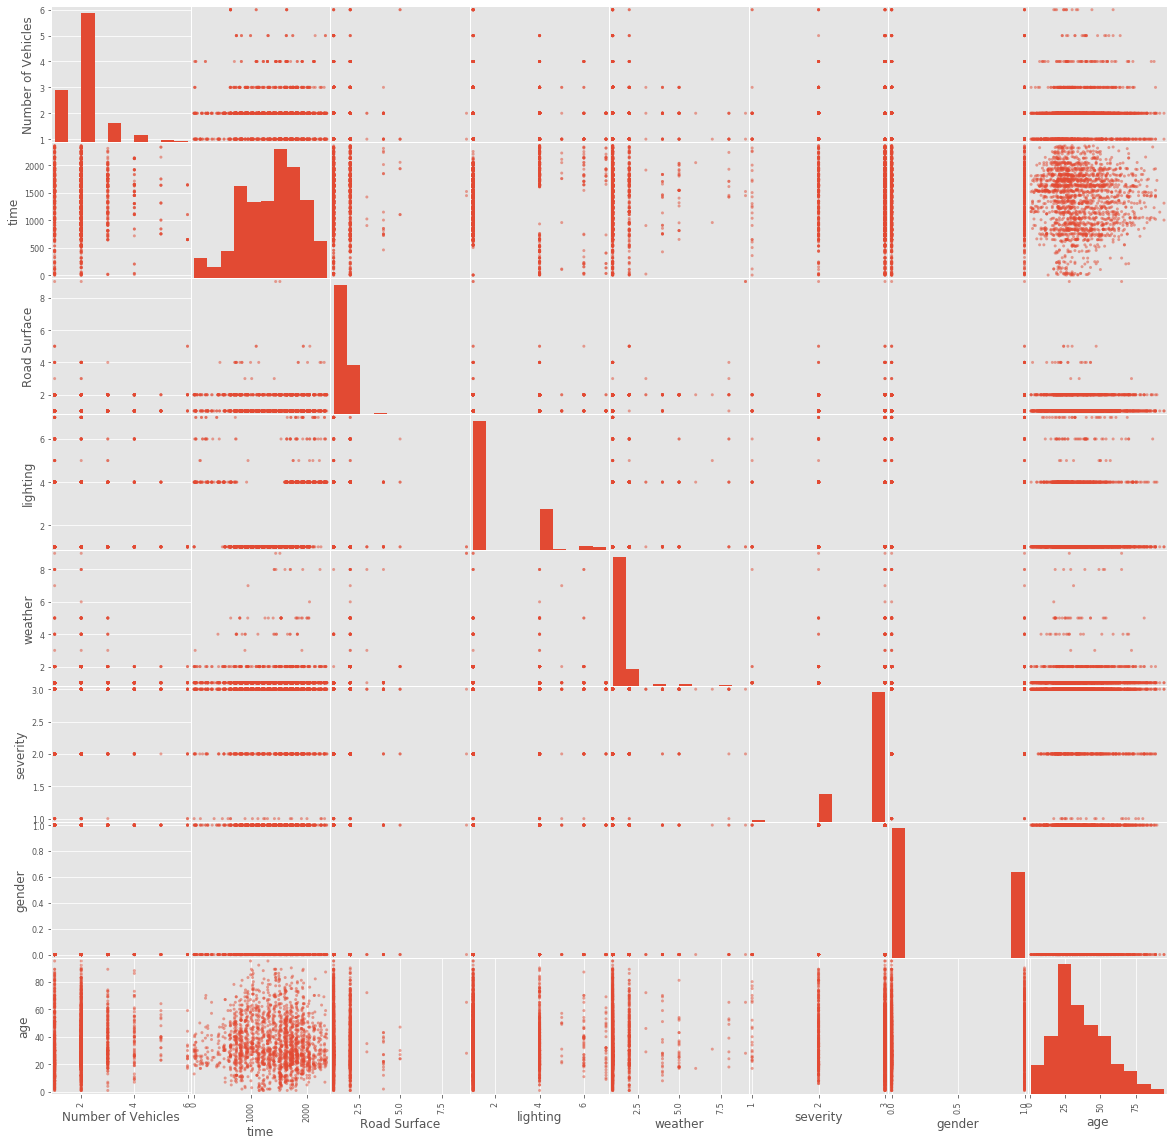

In [242]:
#I'll now show the relationships between variables using a scatter matrix
pd.plotting.scatter_matrix(df, figsize=(20,20));

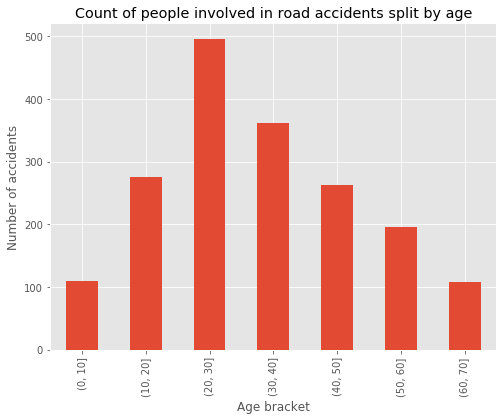

In [267]:
out = pd.cut(df.age, bins=[0,10,20,30,40,50,60,70], include_lowest=False)
ax= out.value_counts(sort=False).plot.bar(figsize=(8,6))
plt.xlabel("Age bracket")
plt.ylabel("Number of accidents")
plt.title("Count of people involved in road accidents split by age")
plt.show()

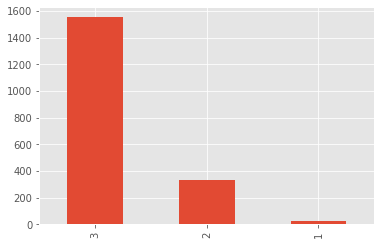

In [200]:
df['severity'].value_counts().plot(kind='bar')

The majority of accidents are minor(3). This will mean that any ML model will have a hard time predicting more severe accidents due to the lack of data

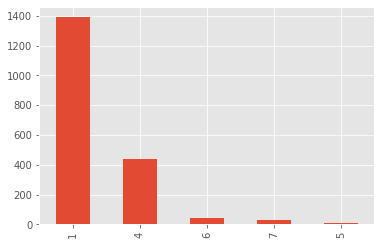

In [201]:
df['lighting'].value_counts().plot(kind='bar')

Most accidents happen in poor lighting conditions(1), the second highest accident prone lighting conditions is in ok lighting conditions(4)

27 year olds are most likely to have an accident. However it looks like 20-30 year old males are most likely to have an accident.

In [204]:
df.groupby(['gender'])['severity'].value_counts(normalize=True)

gender  severity
0       3           0.783290
        2           0.201044
        1           0.015666
1       3           0.858839
        2           0.135884
        1           0.005277
Name: severity, dtype: float64

males are also more likely to get into more severe accidents

In [205]:
df.groupby(['weather'])['severity'].value_counts(normalize=True)

weather  severity
1        3           0.814452
         2           0.173913
         1           0.011635
2        3           0.800000
         2           0.190698
         1           0.009302
3        3           1.000000
4        3           0.894737
         2           0.105263
5        3           0.800000
         2           0.200000
6        3           1.000000
7        3           1.000000
8        3           0.750000
         1           0.125000
         2           0.125000
9        2           0.500000
         3           0.500000
Name: severity, dtype: float64

<b>Next, I want to see if we can predict the severity of a crash based on features available from the dataset. If accurate, the models can be used to alert drivers under 'high risk' conditions which is a preventative measure

#### Feature Selection

In [206]:
X = df[['age','gender','weather','lighting']]
X[0:5]

,age,gender,weather,lighting
0,6,1,1,1
1,9,0,1,1
2,39,1,1,1
3,5,0,1,1
4,8,1,1,1


In [207]:
y = df['severity'].values
y[0:5]

array([3, 3, 3, 3, 3])

### Normalise data
data standardisation give data zero mean and unit variance

In [208]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.6252,  1.2312, -0.2965, -0.5848],
       [-1.4615, -0.8122, -0.2965, -0.5848],
       [ 0.1746,  1.2312, -0.2965, -0.5848],
       [-1.6797, -0.8122, -0.2965, -0.5848],
       [-1.5161,  1.2312, -0.2965, -0.5848]])

### Classification Modelling

#### KNN

In [209]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1525, 4) (1525,)
Test set: (382, 4) (382,)


In [210]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 3
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [211]:
# just for sanity chaeck
yhat = kNN_model.predict(X_test)
yhat[0:5]

array([3, 3, 3, 3, 3])

In [212]:
# Best k
Ks=20
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.7277, 0.6335, 0.7539, 0.7382, 0.7775, 0.7539, 0.7775, 0.7827,
       0.7932, 0.7906, 0.7932, 0.7853, 0.7932, 0.7932, 0.7958, 0.7958,
       0.7958, 0.7958, 0.7958])

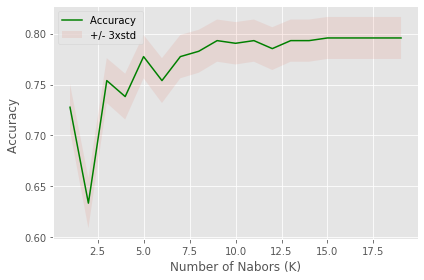

In [213]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [214]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7958115183246073 with k= 15


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        75
           3       0.80      1.00      0.89       304

    accuracy                           0.80       382
   macro avg       0.27      0.33      0.30       382
weighted avg       0.63      0.80      0.71       382

Confusion matrix, without normalization
[[  0   0   3]
 [  0   0  75]
 [  0   0 304]]


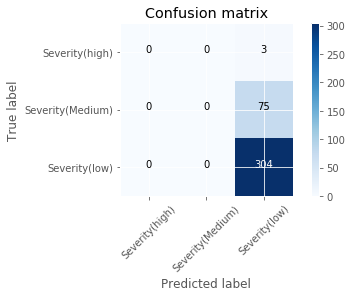

In [221]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3])
np.set_printoptions(precision=4)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(high)','Severity(Medium)','Severity(low)'],normalize= False,  title='Confusion matrix')

### Decision Tree

In [222]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [223]:
yhat = DT_model.predict(X_test)
yhat

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.01      0.03        75
           3       0.80      0.99      0.88       304

    accuracy                           0.79       382
   macro avg       0.38      0.34      0.30       382
weighted avg       0.70      0.79      0.71       382

Confusion matrix, without normalization
[[  0   0   3]
 [  0   1  74]
 [  0   2 302]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


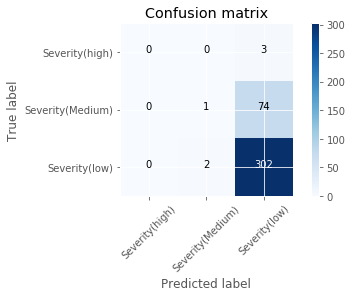

In [224]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3])
np.set_printoptions(precision=4)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(high)','Severity(Medium)','Severity(low)'],normalize= False,  title='Confusion matrix')

### SVM

In [225]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [226]:
yhat = SVM_model.predict(X_test)
yhat

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        75
           3       0.80      1.00      0.89       304

    accuracy                           0.80       382
   macro avg       0.27      0.33      0.30       382
weighted avg       0.63      0.80      0.71       382

Confusion matrix, without normalization
[[  0   0   3]
 [  0   0  75]
 [  0   0 304]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


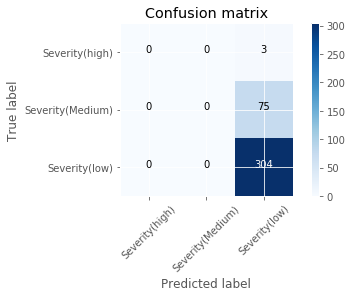

In [227]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3])
np.set_printoptions(precision=4)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(high)','Severity(Medium)','Severity(low)'],normalize= False,  title='Confusion matrix')

### Logistic Regression

In [228]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [229]:
yhat = LR_model.predict(X_test)
yhat

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        75
           3       0.80      1.00      0.89       304

    accuracy                           0.80       382
   macro avg       0.27      0.33      0.30       382
weighted avg       0.63      0.80      0.71       382

Confusion matrix, without normalization
[[  0   0   3]
 [  0   0  75]
 [  0   0 304]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


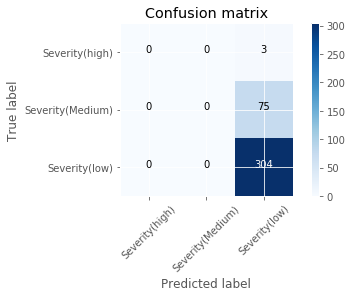

In [230]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3])
np.set_printoptions(precision=4)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(high)','Severity(Medium)','Severity(low)'],normalize= False,  title='Confusion matrix')

## Model evaluation

In [171]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [173]:
knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.80
KNN F1-score: 0.71


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [174]:
DT_yhat = DT_model.predict(X_test)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(y_test, DT_yhat))
print("DT F1-score: %.2f" % f1_score(y_test, DT_yhat, average='weighted') )

DT Jaccard index: 0.79
DT F1-score: 0.71


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [175]:
SVM_yhat = SVM_model.predict(X_test)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(y_test, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(y_test, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.80
SVM F1-score: 0.71


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [176]:
LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("LR F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

LR Jaccard index: 0.80
LR F1-score: 0.71
LR LogLoss: 0.55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


### Results

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.80    | 0.71     | NA      |
| Decision Tree      | 0.79    | 0.71     | NA      |
| SVM                | 0.80    | 0.71     | NA      |
| LogisticRegression | 0.80    | 0.71     | 0.55    |

## Conclusion

We have found some trends in the dataset ranging from who is the most likely to crash and at what time they are most likely to crash. Unfortunately the classification models didn't do too well at predicting severe crashes. I think it's because the dataset has few severe cases so the models have not got enough data to learn sufficiently. 